In [79]:
import seaborn as sns
sns.set()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [80]:
#df = pd.read_excel('F:/Downloads/Reading.xlsx')
df = pd.read_csv('/home/ksooklall/Documents/Reading.xlsc', converters={'date': pd.to_datetime})
df = df.drop(['Unnamed: 8', 'Unnamed: 0'], axis=1).dropna(subset=['book'])
df.head()

,date,book,author,time_start,time_end,start_pg,end_pg,comment
0,2018-12-31,How Not to Be Wrong The Power of Mathematical ...,jordan ellenberg,15:45:00,16:20:00,233,240,Started
1,2019-01-01,How Not to Be Wrong The Power of Mathematical ...,jordan ellenberg,22:56:00,23:11:00,240,248,NaN
2,2019-01-02,How Not to Be Wrong The Power of Mathematical ...,jordan ellenberg,23:00:00,23:30:00,248,252,NaN
3,2019-01-03,How I Killed Pluto and Why It Had It Coming,Mike Brown,23:00:00,23:45:00,1,14,NaN
4,2019-01-04,How I Killed Pluto and Why It Had It Coming,Mike Brown,23:00:00,23:45:00,14,20,NaN


In [81]:
df.dtypes

date          datetime64[ns]
book                  object
author                object
time_start            object
time_end              object
start_pg               int64
end_pg                 int64
comment               object
dtype: object

In [82]:
# How many books read and what were they
total = df['book'].nunique()
books = df['book'].unique().tolist()
print(total)
print(books)

10
['How Not to Be Wrong The Power of Mathematical Thinking', 'How I Killed Pluto and Why It Had It Coming', 'Fail', 'The Physics of God', 'Deep Learning', 'A Gentleman in Moscow', 'Algorithms to Live By', 'Batman and Ethics', 'Where Do I Begin', 'How to win friends & Influence people in the digital age']


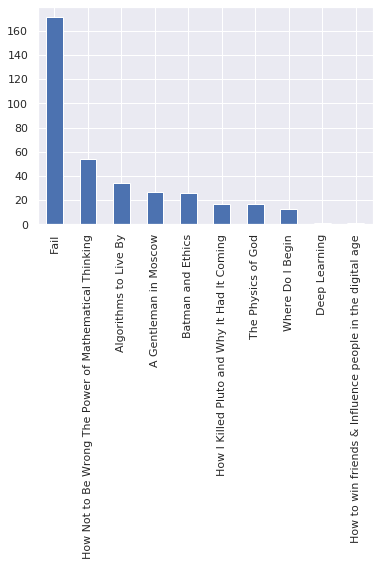

In [83]:
# How many day it took to read each book
df['book'].value_counts().plot(kind='bar')

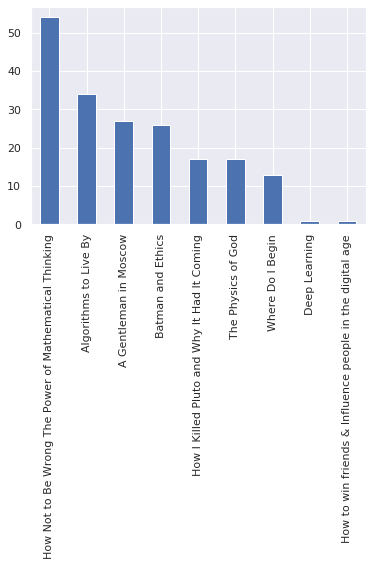

In [84]:
# Remove fail as it doesn't count as book
book_df = df[df['book'] != 'Fail']
book_df['book'].value_counts().plot(kind='bar')

In [85]:
# How many pages was each book
book_df.drop_duplicates(['book'], keep='last')[['book', 'end_pg']]

,book,end_pg
21,How I Killed Pluto and Why It Had It Coming,262
41,Deep Learning,0
46,The Physics of God,182
147,How Not to Be Wrong The Power of Mathematical ...,441
181,A Gentleman in Moscow,462
280,Algorithms to Live By,262
323,Where Do I Begin,275
358,Batman and Ethics,238
361,How to win friends & Influence people in the d...,3


In [86]:
book_df = df[df['book'].notnull() & (df['book'] != 'Fail')]
book_df.drop_duplicates(['book'], keep='last')[['book', 'end_pg']]

,book,end_pg
21,How I Killed Pluto and Why It Had It Coming,262
41,Deep Learning,0
46,The Physics of God,182
147,How Not to Be Wrong The Power of Mathematical ...,441
181,A Gentleman in Moscow,462
280,Algorithms to Live By,262
323,Where Do I Begin,275
358,Batman and Ethics,238
361,How to win friends & Influence people in the d...,3


In [87]:
# Reasons for failure
fail_df = df[df['book'] == 'Fail']
fail_df.head()

,date,book,author,time_start,time_end,start_pg,end_pg,comment
5,2019-01-05,Fail,Fail,0,0,0,0,No clue
16,2019-01-16,Fail,Fail,0,0,0,0,Holiday party
25,2019-01-25,Fail,Fail,0,0,0,0,College meet up
26,2019-01-26,Fail,Fail,0,0,0,0,Family game night
36,2019-02-05,Fail,Fail,0,0,0,0,Team drinks after work


In [88]:
count = fail_df['comment'].nunique()
print('{} reasons for not reading'.format(count))

76 reasons for not reading


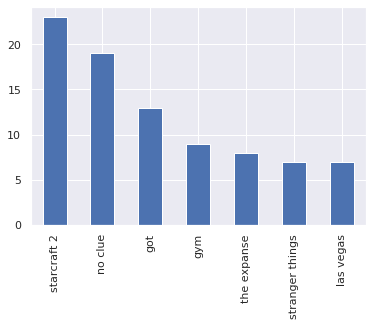

In [89]:
fail_df['comment'].str.lower().value_counts().nlargest(7).plot(kind='bar')

In [90]:
fail_df['comment'].str.lower().value_counts().sort_values(ascending=False).head(20)

starcraft 2        23
no clue            19
got                13
gym                 9
the expanse         8
stranger things     7
las vegas           7
family event        5
birthday            4
pokemon go          3
wedding             3
jack ryan           3
poker night         3
sleep over          2
kaggle              2
rock climbing       2
dinner              2
no excuse           2
climbing            2
netflix             2
Name: comment, dtype: int64

In [91]:
fail_df['comment'].str.lower().value_counts().nsmallest(7)

raj birthday              1
sushi at hanna            1
manny birthday            1
car problem               1
tesla k80 drivers         1
friends night out         1
4th of july fire works    1
Name: comment, dtype: int64

In [92]:
book_df = book_df[book_df['book'] != 'Deep Learning']
# how fast do i read

In [93]:
# Most pages read in one day
df['pages_read'] = df['end_pg'] - df['start_pg']
df.loc[df['pages_read'].idxmax()]

# Amazing how the day i read the most I had no comments

date          2019-11-08 00:00:00
book             Where Do I Begin
author                Elvis Duran
time_start               23:01:00
time_end                 23:48:00
start_pg                      100
end_pg                        145
comment                       NaN
pages_read                     45
Name: 312, dtype: object

In [94]:
# longest reading day
te = pd.to_datetime(book_df['time_end'].astype(str), format='%H:%M:%S')
ts = pd.to_datetime(book_df['time_start'].astype(str), format='%H:%M:%S')
book_df['time_reading'] = ((te - ts).dt.seconds / 60).astype(int)

In [95]:
bmean, bstd = book_df['time_reading'].mean(), book_df['time_reading'].std()

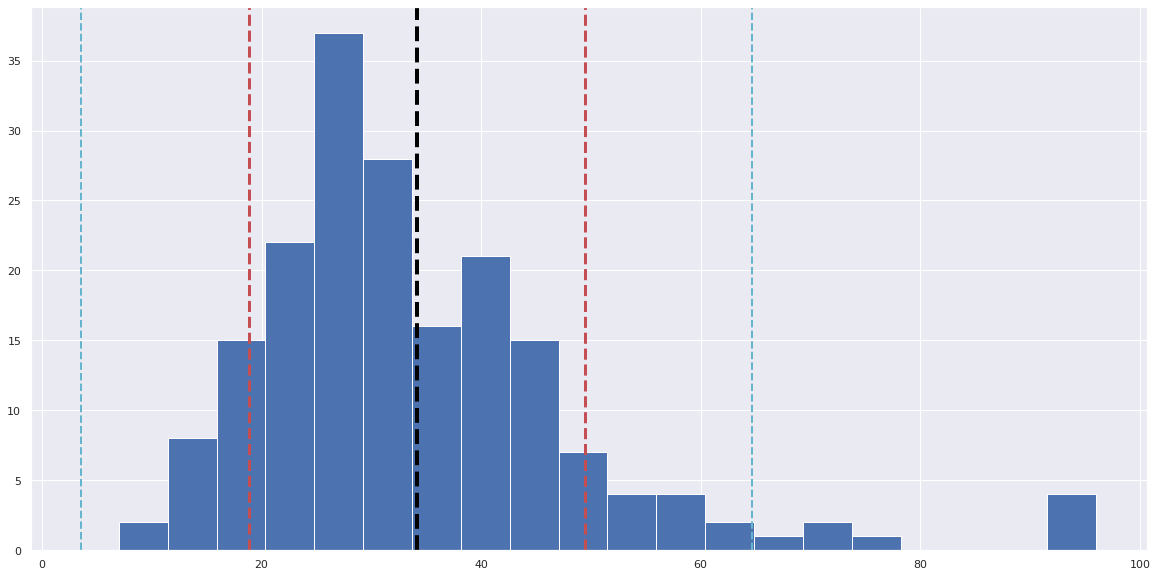

In [96]:
plt.axvline(bmean, color='black', linestyle='dashed', linewidth=4)
plt.axvline(bmean + bstd, color='r', linestyle='dashed', linewidth=3)
plt.axvline(bmean - bstd, color='r', linestyle='dashed', linewidth=3)
plt.axvline(bmean + 2 * bstd, color='c', linestyle='dashed', linewidth=2)
plt.axvline(bmean - 2 * bstd, color='c', linestyle='dashed', linewidth=2)

book_df['time_reading'].hist(figsize=(20, 10), bins=20)

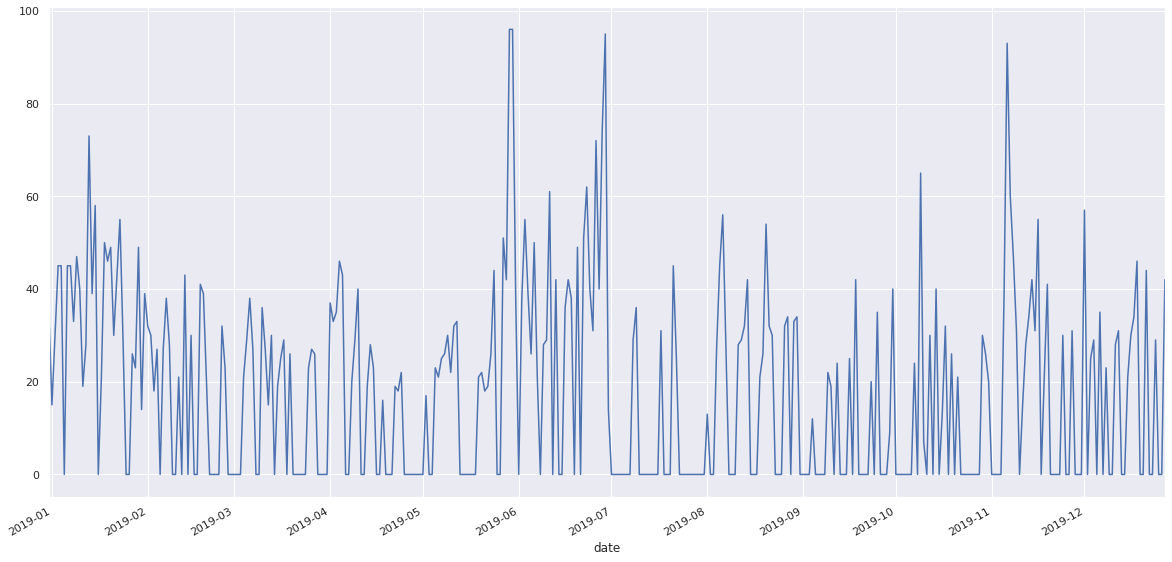

In [97]:
df.merge(book_df[['date', 'time_reading']], on='date', how='left').set_index('date')['time_reading'].fillna(0).plot(figsize=(20, 10))

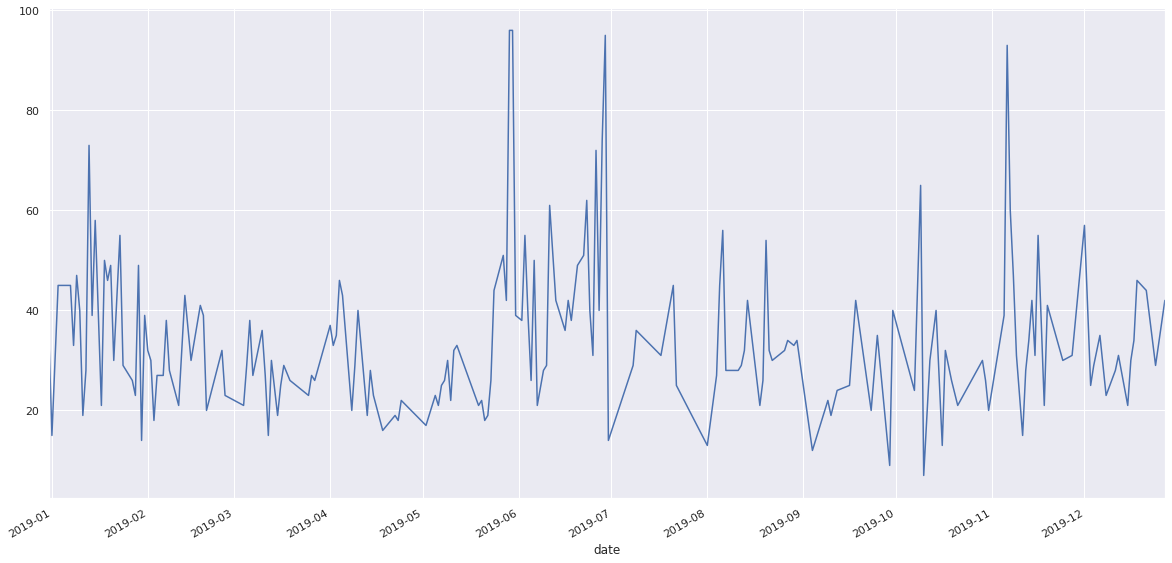

In [98]:
book_df.set_index('date')['time_reading'].plot(figsize=(20, 10))

In [99]:
# a little more than an hour and a half
book_df.loc[book_df['time_reading'].idxmax()]

date              2019-05-29 00:00:00
book            A Gentleman in Moscow
author                    Amor Towles
time_start                   22:50:00
time_end                     00:26:00
start_pg                           18
end_pg                             48
comment                    Baudelaire
time_reading                       96
Name: 149, dtype: object

In [100]:
df = df.merge(book_df['time_reading'], left_index=True, right_index=True, how='outer')

,date,book,author,time_start,time_end,start_pg,end_pg,comment,pages_read,time_reading
0,2018-12-31,How Not to Be Wrong The Power of Mathematical ...,jordan ellenberg,15:45:00,16:20:00,233,240,Started,7,35.0
1,2019-01-01,How Not to Be Wrong The Power of Mathematical ...,jordan ellenberg,22:56:00,23:11:00,240,248,NaN,8,15.0
2,2019-01-02,How Not to Be Wrong The Power of Mathematical ...,jordan ellenberg,23:00:00,23:30:00,248,252,NaN,4,30.0
3,2019-01-03,How I Killed Pluto and Why It Had It Coming,Mike Brown,23:00:00,23:45:00,1,14,NaN,13,45.0
4,2019-01-04,How I Killed Pluto and Why It Had It Coming,Mike Brown,23:00:00,23:45:00,14,20,NaN,6,45.0


In [147]:
tmp = df['time_start'].where(df['time_start'].eq('0'), 1).astype(int)
tmp = tmp.groupby(tmp.eq(0).cumsum()).cumsum()

end = tmp.idxmax()
length = tmp.max()

In [152]:
longest_streak = df.loc[end - length + 1:end]
longest_streak

,date,book,author,time_start,time_end,start_pg,end_pg,comment,pages_read,time_reading
6,2019-01-06,How I Killed Pluto and Why It Had It Coming,Mike Brown,23:00:00,23:45:00,20,28,NaN,8,45.0
7,2019-01-07,How I Killed Pluto and Why It Had It Coming,Mike Brown,23:00:00,23:45:00,28,42,NaN,14,45.0
8,2019-01-08,How I Killed Pluto and Why It Had It Coming,Mike Brown,22:40:00,23:13:00,42,47,NaN,5,33.0
9,2019-01-09,How I Killed Pluto and Why It Had It Coming,Mike Brown,22:10:00,22:57:00,47,72,NaN,25,47.0
10,2019-01-10,How I Killed Pluto and Why It Had It Coming,Mike Brown,22:40:00,23:20:00,72,86,NaN,14,40.0
11,2019-01-11,How I Killed Pluto and Why It Had It Coming,Mike Brown,23:34:00,23:53:00,86,94,NaN,8,19.0
12,2019-01-12,How I Killed Pluto and Why It Had It Coming,Mike Brown,14:57:00,15:25:00,94,102,NaN,8,28.0
13,2019-01-13,How I Killed Pluto and Why It Had It Coming,Mike Brown,23:12:00,00:25:00,102,130,NaN,28,73.0
14,2019-01-14,How I Killed Pluto and Why It Had It Coming,Mike Brown,22:25:00,23:04:00,130,140,NaN,10,39.0
15,2019-01-15,How I Killed Pluto and Why It Had It Coming,Mike Brown,22:44:00,23:42:00,140,166,NaN,26,58.0


In [155]:
print(longest_streak['time_reading'].sum() % 60)
longest_streak['pages_read'].sum()

7.0


146

The longest reading streak was at the start of the year and last 10 days in which time I read about 7hrs and 146 pages

## Preferred time of day to read

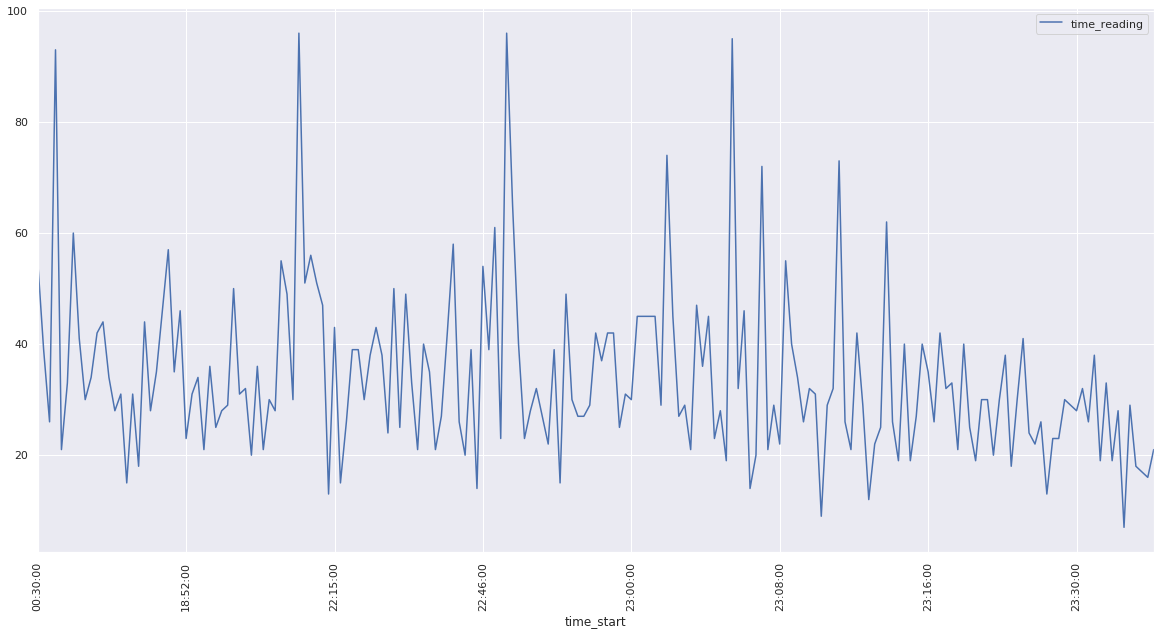

In [179]:
#plt.axvline(1, color='b', linestyle='yellow', linewidth=3)
book_df.sort_values('time_start', ascending=True).plot(x='time_start', y='time_reading', rot=90, figsize=(20, 10))